In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional, Tuple
import numdifftools as nd
import sympy as sp

In [2]:
def vjacobi(
    fn: Callable,
    x: np.ndarray,
    p: np.ndarray,
    dp: Optional[np.ndarray] = None,
    *,
    rtol: float = 0.0,
    debug: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the Jacobi matrix of a vector-valued function.
    """

    assert p.ndim == 1
    y = fn(x, p)

    if dp is None:
        # dp = sqrt(eps) * p optimal for forward/backward difference
        # https://en.wikipedia.org/wiki/Numerical_differentiation#Step_size
        sqrt_eps = np.sqrt(np.finfo(y.dtype).resolution)
        dp = np.where(p == 0, sqrt_eps, np.abs(p) * sqrt_eps)
    else:
        assert dp.ndim == 1
        assert np.all(dp >= 0)
    assert rtol >= 0

    y_shape = np.shape(y)
    jac = np.empty((*y_shape, len(p)))
    h = np.zeros(len(p))

    for i, dpi in enumerate(dp):
        if i > 0:
            h[i - 1] = 0

        # skip this variable if dp[i] is zero
        if dpi == 0:
            jac[:, i] = 0
            continue

        converged = np.zeros(y_shape, dtype=bool)
        prev_esq = np.full(y_shape, np.inf)

        # try to converge by making step size smaller
        h[i] = dpi
        for it in range(20):
            assert h[i] > 0

            todo = ~converged

            # compute central derivative,
            # computing dx like this improves precision, see
            # https://en.wikipedia.org/wiki/Numerical_differentiation#Step_size
            pp = p + h
            pm = p - h
            x_todo = x[todo]
            y_todo = y[todo]
            yp = fn(x_todo, pp)
            ym = fn(x_todo, pm)
            dp = (yp - y_todo) / (pp[i] - p[i])
            dm = (ym - y_todo) / (pm[i] - p[i])
            d = 0.5 * (dp + dm)
            derr = np.abs(dp - dm) * 10

            if rtol > 0:
                below_tolerance = (derr <= rtol * np.abs(d))
                newly_converged = ~converged
                newly_converged[todo] = below_tolerance
                if np.any(newly_converged):
                    jac[newly_converged, i] = d[below_tolerance]
                    converged |= newly_converged
                    prev_esq[newly_converged] = 0 # to skip check for convergence below
                    m = ~below_tolerance
                    derr = derr[m]
                    d = d[m]
                    todo = ~converged

                # early stop when everything is below tolerance
                if np.all(converged):
                    break

            # check for convergence of stepping algorithm
            esq = derr * derr
            todo_converging = esq < prev_esq[todo]

            # points have converged, which were previously converging
            # and are now diverging
            converged[todo] |= ~todo_converging

            if it == 0:
                # points are divergent which "converged" while prev_esq is infinite
                bad = converged & ~np.isfinite(prev_esq)
                if np.any(bad):
                    if debug:
                        print(
                            f"jacobi: ipar={i} divergence detected "
                            f"in {np.sum(bad)} points"
                        )
                    jac[bad, i] = np.nan

            converging = ~converged
            if np.any(converging):
                jac[converging, i] = d[todo_converging]

            if debug > 0:
                print(
                    f"jacobi: ipar={i} iter={it} h={h[i]:.3e} "
                    f"{np.sum(converged)} of {np.prod(converged.shape)} converged")
                if debug > 1:
                    print(
                        f"d={d}\n"
                        f"derr={derr}\n"
                        f"rtol * abs(d)={rtol * np.abs(d)}"
                    )

            if np.all(converged):
                break

            prev_esq[todo] = esq
            h[i] *= 0.1
    
    return y, jac

calls processed 3
points processed 603


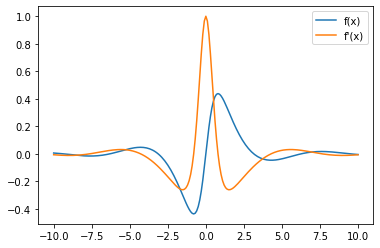

In [21]:
x = np.linspace(-10, 10, 201)

class F:
    nf = 0
    nx = 0

    def __init__(self, *args):
        if len(args) == 1:
            self.x, = args

    def __call__(self, *args):
        if len(args) == 2:
            x, p = args
        else:
            p, = args
            x = self.x
        self.nf += 1
        self.nx += len(x)
        y = (x + p)
        return np.sin(y)/(y**2 + 1)
    
f = F()
p = np.array([0.0])
# fx, fpx = vjacobi(f, x, p, dp=np.array([1e-9]), rtol=0, debug=1)
fx, fpx = vjacobi(f, x, p, rtol=1e-3, debug=1)
print("calls processed", f.nf)
print("points processed", f.nx)

plt.plot(x, fx, label="f(x)")
plt.plot(x, fpx, label="f'(x)")
plt.legend();

In [22]:
%%timeit f = F(x)
nd.Derivative(f)(0);

28.2 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%%timeit f = F()
vjacobi(f, x, p, rtol=0)

280 µs ± 12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
%%timeit f = F()
vjacobi(f, x, p, rtol=1e-3)

90.2 µs ± 6.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [25]:
f = F(x)
fp1 = nd.Derivative(f)(0)
print(f.nf, f.nx)

30 6030


In [26]:
f = F()
fp2 = vjacobi(f, x, p, rtol=0)[1][:, 0]
print(f.nf, f.nx)

9 1265


In [27]:
f = F()
fp3 = vjacobi(f, x, p, rtol=1e-3)[1][:, 0]
print(f.nf, f.nx)

3 603


In [28]:
# compute exact derivative of sin(x)/x
fp = sp.lambdify("x", sp.diff("sin(x)/(x**2 + 1)").simplify(), "numpy")(x)

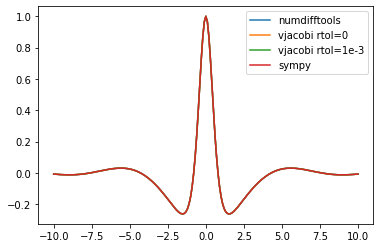

In [29]:
plt.plot(x, fp1, label="numdifftools")
plt.plot(x, fp2, label="vjacobi rtol=0")
plt.plot(x, fp3, label="vjacobi rtol=1e-3")
plt.plot(x, fp, label="sympy")
plt.legend();

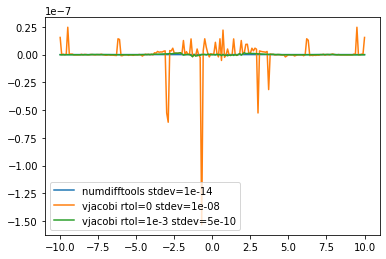

In [30]:
plt.plot(x, fp1-fp, label=f"numdifftools stdev={np.nanstd(fp1-fp):.0e}")
plt.plot(x, fp2-fp, label=f"vjacobi rtol=0 stdev={np.nanstd(fp2-fp):.0e}")
plt.plot(x, fp3-fp, label=f"vjacobi rtol=1e-3 stdev={np.nanstd(fp3-fp):.0e}")
plt.legend();